# User Variables

In [2]:
MIN_SUPPORTS = 0
K_TOP_RULES = 20

TARGETS = [
    "ottvod_C_paid_in",
    "ottvod_C_paid_out",
    "ottvod_C_free_in",
    "ottvod_C_free_out"
    ]

# Constants

In [3]:
SRGNN_PREDICTIONS = "tmp/docomo_sr-gnn_predictions.csv"
STAMP_PREDICTIONS = "tmp/docomo_stamp_predictions.csv"
NARM_PREDICTIONS = "tmp/docomo_narm_predictions.csv"

MAX_HIT_RATE = 6
NB_ITEMS = 12
MIN_DEGREE = 1

# Imports

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from upsetplot import UpSet
import itertools
from more_itertools import powerset
import math

# LFIT Rules analysis

In [5]:
variable_color = {
    "ottvod_A_paid_in": "#ff9724",
    "ottvod_A_paid_out": "#675ef6",

    "ottvod_B_paid_in": "#f65eea",
    "ottvod_B_paid_out": "#1aff36",
    
    "ottvod_C_paid_in": "#ff1a1a",
    "ottvod_C_paid_out": "#03e48d",
    "ottvod_C_free_in": "#ff5b5b",
    "ottvod_C_free_out": "#49d194",

    "cinema": "#911bfc",
    "theme_park": "#94cf51",
    "fast_food": "#fdfd13",
    "toy_mall": "#fdfd13",
}

keys = list(variable_color.keys())
for i in keys:
    variable_color["last("+i+")"] = variable_color[i]

def color_blend(variables):
    #r, g, b = (tuple(int(variable_color[variables[0]].lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
    r, g, b = 0, 0, 0
    for var in variables:
        r_, g_, b_ = (tuple(int(variable_color[var].lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
        r += ((255 - r_)**2)/2
        g += ((255 - g_)**2)/2
        b += ((255 - b_)**2)/2
        #a += color[3]

    r = (255 - math.sqrt(r)) / 255
    g = (255 - math.sqrt(g)) / 255
    b = (255 - math.sqrt(b)) / 255
    
    return (max(0,r), max(0,g), max(0,b), 1.0)

color_blend(["ottvod_A_paid_in", "ottvod_B_paid_in"])

(0.975043290075769, 0.4685080808415626, 0.38993448647227424, 1.0)

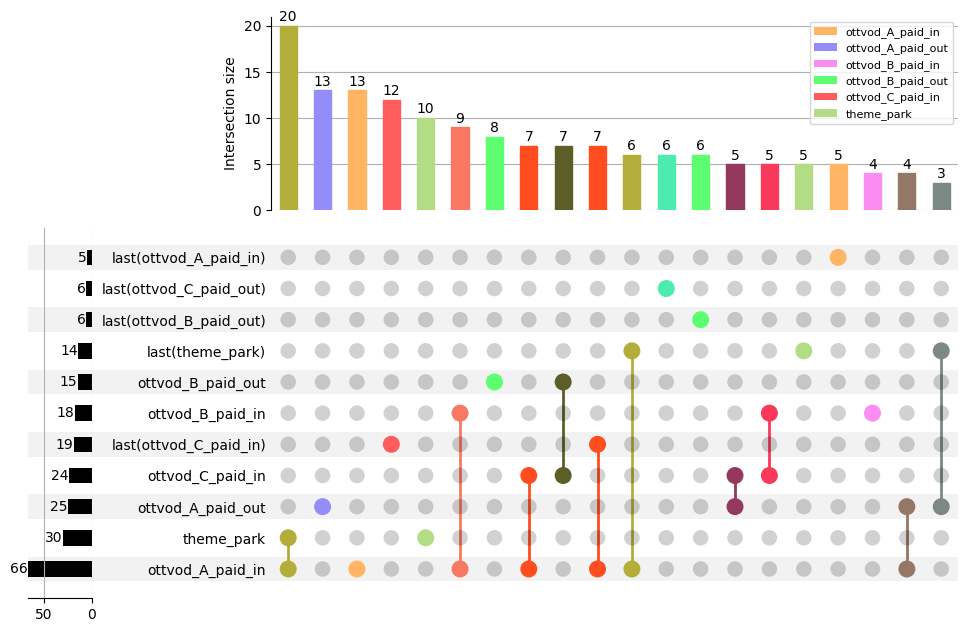

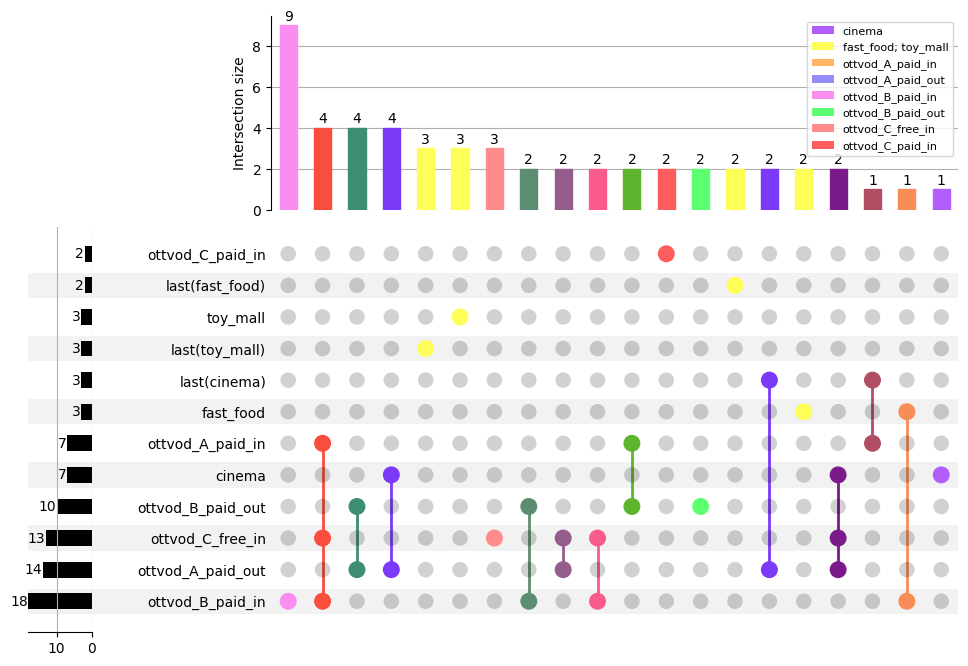

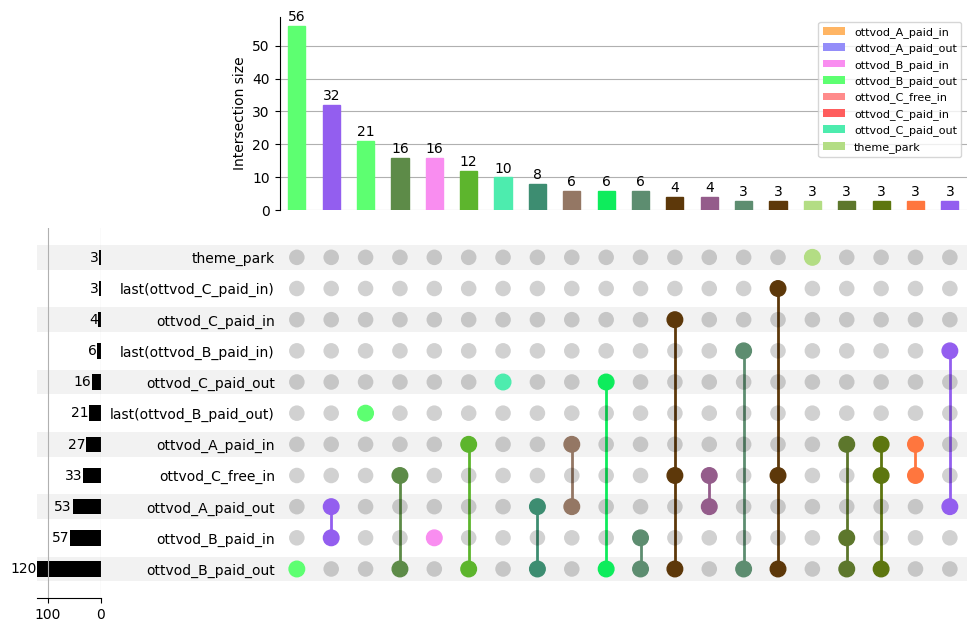

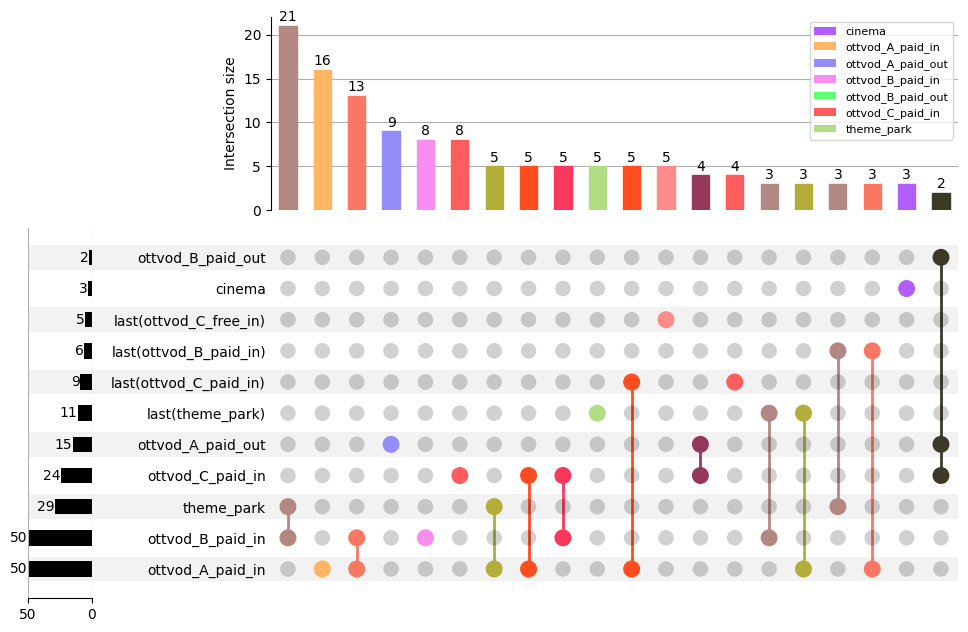

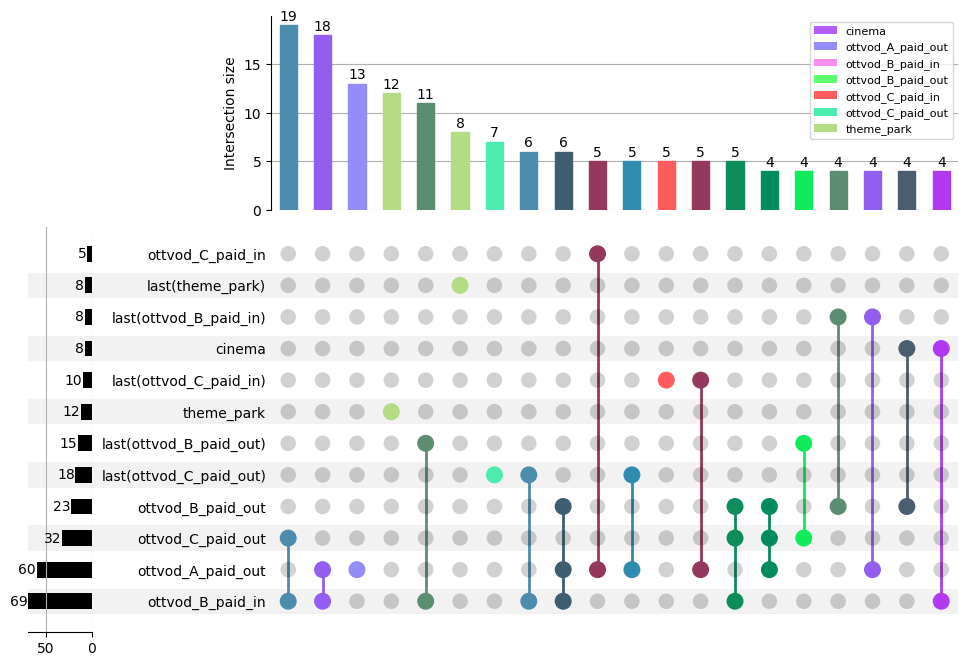

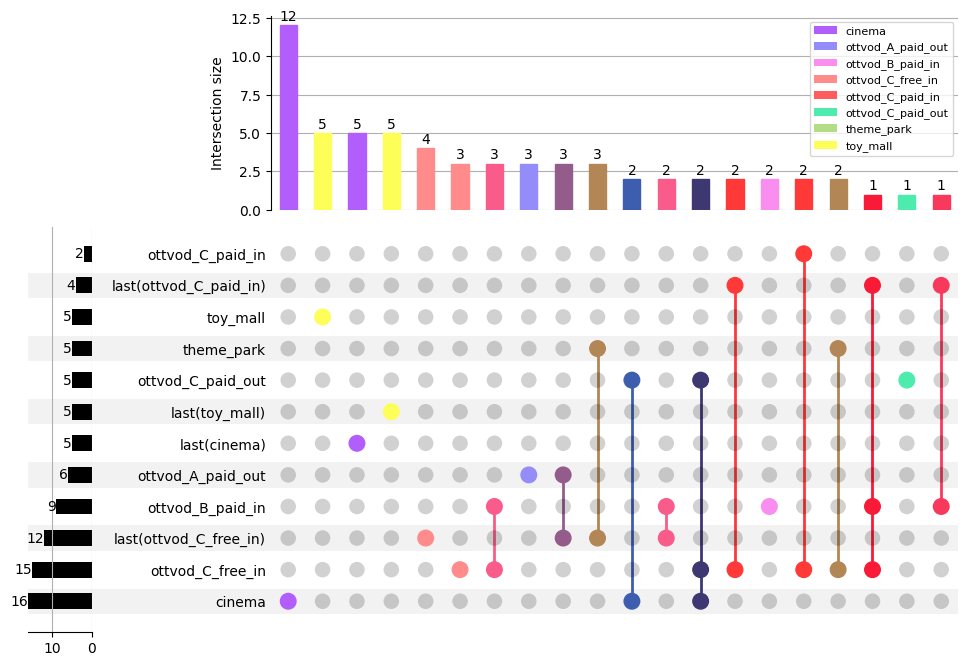

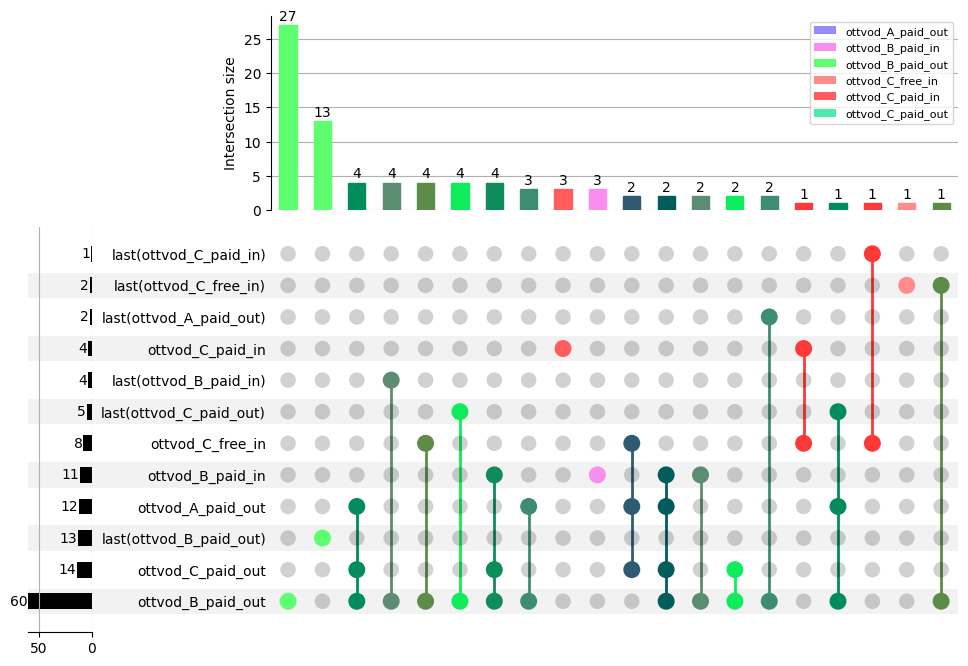

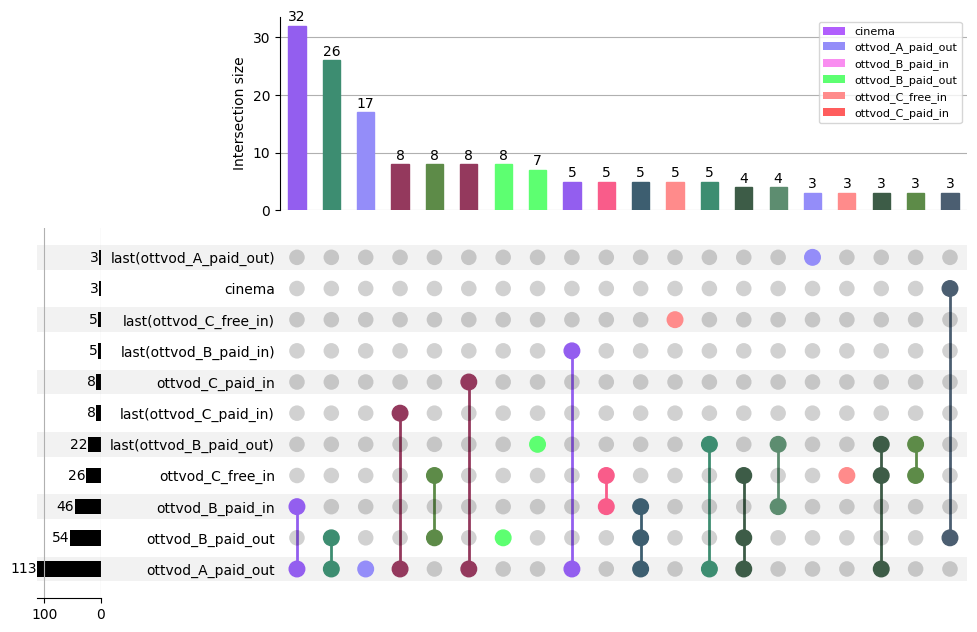

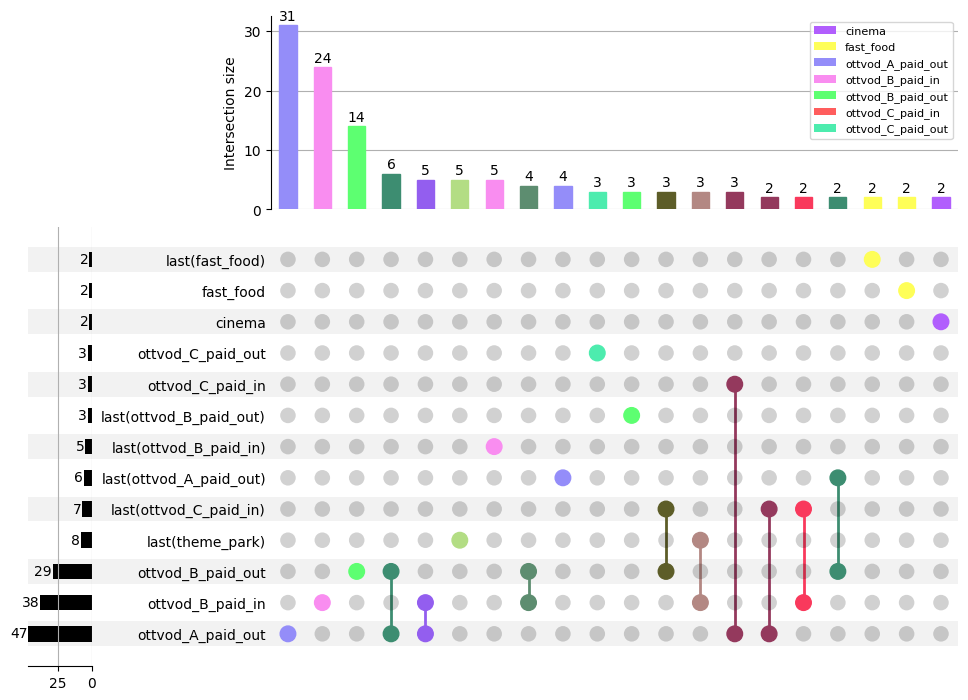

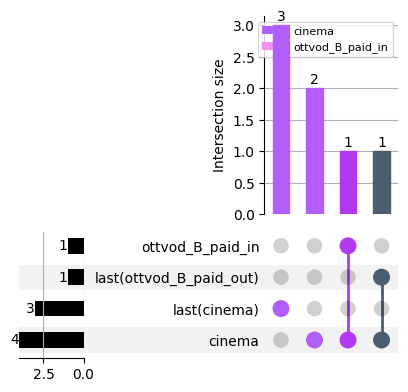

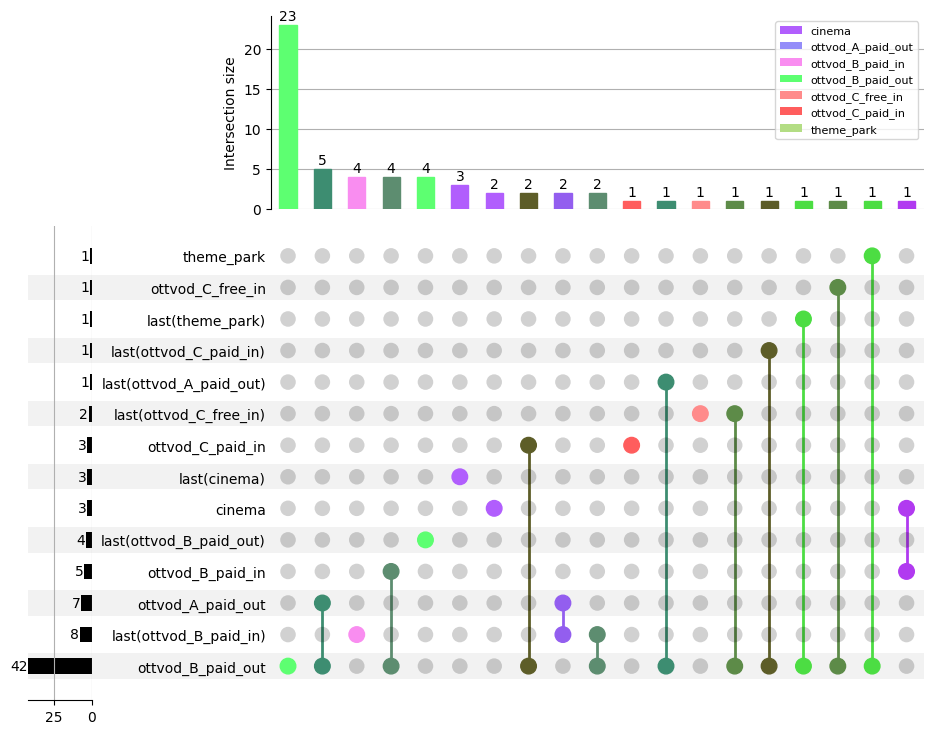

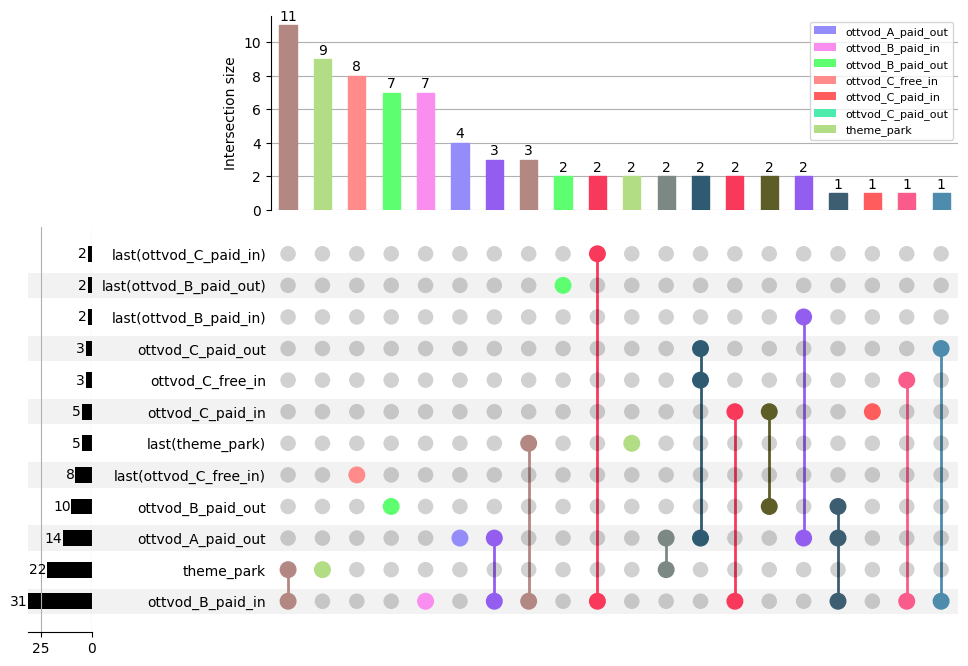

In [6]:
for model in ["sr-gnn", "stamp", "narm"]:
    df_rules = pd.read_csv("tmp/"+model+"_lfit_output.csv")
    #display(df_rules)

    # Extract existing conditions
    condition_values = set()
    decoded_values = []
    for idx, row in df_rules.iterrows():
        conditions = [i.strip().replace("'","") for i in row["conditions"].replace("[","").replace("]","").split(", ")]
        decoded_values += [conditions]
        for i in conditions:
            condition_values.add(i)
    df_rules["conditions"] = decoded_values

    condition_values = list(condition_values)
    condition_values.sort()
    df_conditions = pd.DataFrame(columns=["head"]+condition_values)

    for idx, row in df_rules.iterrows():
        data = {key:[False] for key in condition_values}
        data["head"] = row["head_value"]
        for condition in row["conditions"]:
            data[condition] = [True]
        df_conditions = pd.concat([df_conditions, pd.DataFrame(data)], axis=0).astype({key:bool for key in condition_values})

    #display(df_conditions)
    df_conditions["support"] = df_rules["rule_positive_supports"].values

    # TODO: generalize
    heads = [i for i in list(df_rules["head_value"].unique()) if i in TARGETS]
    heads.sort()

    for idx, head in enumerate(heads):
        df = df_conditions[df_conditions["head"] == head]
        df = df.drop(["head"],axis=1)

        df = df.groupby([c for c in list(df.columns) if c != "support"]).sum(numeric_only=True).reset_index().sort_values(["support"],ascending=False).head(K_TOP_RULES)
        #df = df[df["support"] >= MIN_SUPPORTS].reset_index()

        for col in condition_values:
            if (not True in list(df[col].unique())):
                df = df.drop([col], axis=1)
        #display(df)
        conditions = [c for c in list(df.columns) if c != "support"]
        df = df.groupby(conditions).sum(numeric_only=True)
        #display(df)
        upset = UpSet(df, show_counts=True, sort_by="cardinality", sum_over='support', subset_size="sum", min_degree=MIN_DEGREE)

        #display(df)
        for comb in list(powerset(conditions)):
            if (len(comb) > 0):
                label = None
                if len(comb) == 1 and "last" not in comb[0]:
                    label = comb[0]
                upset.style_subsets(present=comb, facecolor=color_blend(comb),label=label)
        params = {'legend.fontsize': 8, "legend.loc": "upper right"}
        with plt.rc_context(params):
            upset.plot()
        #plt.title("Upset plot of the rules of "+head+" for "+model.upper(), loc="right",y=-1.0)
        plt.savefig("tmp/upset_plot_lfit_"+model+"_"+head+".pdf",bbox_inches='tight')
        plt.show()
    

# Attention analysis

In [7]:
def preprocess(df):
    inputs = []
    attentions = []
    predictions = []
    hit_rate = [[] for i in range(0,MAX_HIT_RATE+1)]
    top_predictions = []
    for idx, row in df.iterrows():
        input = [int(i) for i in row["Model_input"].replace("[","").replace("]","").split(", ")]
        inputs += [input]

        attention = [float(i) for i in row["Model_attention"].replace("[","").replace("]","").split(", ")][:len(row["Model_input"])]
        attention = attention[:len(input)]
        min_att = min(attention)
        max_att = max(attention)
        if min_att == max_att:
            attention = [1 for i in attention]
        else:
            attention = [round((i - min_att) / (max_att - min_att),3) for i in attention]
        
        attentions += [attention]

        prediction = [int(i) for i in row["Model_prediction"].replace("[","").replace("]","").split(", ")]
        predictions += [prediction]

        for i in range(1,MAX_HIT_RATE+1):
            hit_rate[i] += [float(row["Expected"] in prediction[:i])]

        top_predictions += [prediction[0]]

    df["Model_attention"] = attentions
    df["Model_input"] = inputs
    df["Model_prediction"] = predictions
    df["top_prediction"] = top_predictions

    for i in range(1,MAX_HIT_RATE+1):
        df["P@"+str(i)] = hit_rate[i]

df = dict()
df["SR-GNN"] = pd.read_csv(SRGNN_PREDICTIONS)
preprocess(df["SR-GNN"])
display(df["SR-GNN"])

df["STAMP"] = pd.read_csv(STAMP_PREDICTIONS)
preprocess(df["STAMP"])
display(df["STAMP"])

df["NARM"] = pd.read_csv(NARM_PREDICTIONS)
preprocess(df["NARM"])
display(df["NARM"])

,Expected,Model_input,Model_attention,Model_prediction,top_prediction,P@1,P@2,P@3,P@4,P@5,P@6
0,10,"[1, 6, 7]","[1.0, 0.787, 0.0]","[2, 10, 4, 9, 12, 1, 11, 3, 8, 5, 6, 7]",2,0.0,1.0,1.0,1.0,1.0,1.0
1,7,"[2, 3, 6]","[0.855, 1.0, 0.0]","[7, 1, 9, 8, 10, 4, 12, 11, 6, 2, 5, 3]",7,1.0,1.0,1.0,1.0,1.0,1.0
2,7,"[2, 3, 6]","[0.855, 1.0, 0.0]","[7, 1, 9, 8, 10, 4, 12, 11, 6, 2, 5, 3]",7,1.0,1.0,1.0,1.0,1.0,1.0
3,7,"[2, 3, 6]","[0.855, 1.0, 0.0]","[7, 1, 9, 8, 10, 4, 12, 11, 6, 2, 5, 3]",7,1.0,1.0,1.0,1.0,1.0,1.0
4,7,"[2, 3, 6]","[0.855, 1.0, 0.0]","[7, 1, 9, 8, 10, 4, 12, 11, 6, 2, 5, 3]",7,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3371,6,"[2, 3, 7]","[1.0, 0.46, 0.0]","[6, 1, 10, 4, 7, 9, 5, 2, 12, 11, 3, 8]",6,1.0,1.0,1.0,1.0,1.0,1.0
3372,6,"[2, 3, 7]","[1.0, 0.46, 0.0]","[6, 1, 10, 4, 7, 9, 5, 2, 12, 11, 3, 8]",6,1.0,1.0,1.0,1.0,1.0,1.0
3373,4,"[7, 6, 5]","[1.0, 0.0, 0.027]","[4, 10, 1, 12, 9, 2, 3, 11, 8, 7, 5, 6]",4,1.0,1.0,1.0,1.0,1.0,1.0
3374,9,"[6, 9, 9, 9]","[1.0, 0.0, 0.0, 0.0]","[9, 8, 12, 11, 4, 10, 7, 2, 5, 1, 6, 3]",9,1.0,1.0,1.0,1.0,1.0,1.0


,Expected,Model_input,Model_attention,Model_prediction,top_prediction,P@1,P@2,P@3,P@4,P@5,P@6
0,10,"[1, 6, 7]","[0.0, 0.776, 1.0]","[2, 4, 10, 12, 9, 3, 1, 5, 11, 8, 6, 7]",2,0.0,0.0,1.0,1.0,1.0,1.0
1,7,"[2, 3, 6]","[0.0, 1.0, 0.07]","[7, 1, 9, 8, 10, 12, 4, 6, 3, 5, 2, 11]",7,1.0,1.0,1.0,1.0,1.0,1.0
2,7,"[2, 3, 6]","[0.0, 1.0, 0.07]","[7, 1, 9, 8, 10, 12, 4, 6, 3, 5, 2, 11]",7,1.0,1.0,1.0,1.0,1.0,1.0
3,7,"[2, 3, 6]","[0.0, 1.0, 0.07]","[7, 1, 9, 8, 10, 12, 4, 6, 3, 5, 2, 11]",7,1.0,1.0,1.0,1.0,1.0,1.0
4,7,"[2, 3, 6]","[0.0, 1.0, 0.07]","[7, 1, 9, 8, 10, 12, 4, 6, 3, 5, 2, 11]",7,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3371,6,"[2, 3, 7]","[0.0, 1.0, 0.575]","[6, 1, 4, 10, 3, 7, 11, 2, 9, 5, 8, 12]",6,1.0,1.0,1.0,1.0,1.0,1.0
3372,6,"[2, 3, 7]","[0.0, 1.0, 0.575]","[6, 1, 4, 10, 3, 7, 11, 2, 9, 5, 8, 12]",6,1.0,1.0,1.0,1.0,1.0,1.0
3373,4,"[7, 6, 5]","[0.699, 0.0, 1.0]","[4, 1, 12, 9, 8, 2, 3, 7, 10, 11, 6, 5]",4,1.0,1.0,1.0,1.0,1.0,1.0
3374,9,"[6, 9, 9]","[1.0, 0.0, 0.0]","[9, 8, 4, 1, 7, 2, 11, 5, 12, 6, 3, 10]",9,1.0,1.0,1.0,1.0,1.0,1.0


,Expected,Model_input,Model_attention,Model_prediction,top_prediction,P@1,P@2,P@3,P@4,P@5,P@6
0,10,"[1, 6, 7]","[0.604, 1.0, 0.0]","[2, 10, 4, 3, 11, 1, 9, 7, 12, 5, 6, 8]",2,0.0,1.0,1.0,1.0,1.0,1.0
1,7,"[2, 3, 6]","[0.133, 1.0, 0.0]","[7, 9, 1, 4, 10, 6, 8, 12, 5, 11, 3, 2]",7,1.0,1.0,1.0,1.0,1.0,1.0
2,7,"[2, 3, 6]","[0.133, 1.0, 0.0]","[7, 9, 1, 4, 10, 6, 8, 12, 5, 11, 3, 2]",7,1.0,1.0,1.0,1.0,1.0,1.0
3,7,"[2, 3, 6]","[0.133, 1.0, 0.0]","[7, 9, 1, 4, 10, 6, 8, 12, 5, 11, 3, 2]",7,1.0,1.0,1.0,1.0,1.0,1.0
4,7,"[2, 3, 6]","[0.133, 1.0, 0.0]","[7, 9, 1, 4, 10, 6, 8, 12, 5, 11, 3, 2]",7,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3371,6,"[2, 3, 7]","[0.184, 1.0, 0.0]","[1, 10, 6, 4, 3, 7, 5, 11, 8, 9, 2, 12]",1,0.0,0.0,1.0,1.0,1.0,1.0
3372,6,"[2, 3, 7]","[0.184, 1.0, 0.0]","[1, 10, 6, 4, 3, 7, 5, 11, 8, 9, 2, 12]",1,0.0,0.0,1.0,1.0,1.0,1.0
3373,4,"[7, 6, 5]","[0.0, 0.044, 1.0]","[4, 10, 1, 3, 9, 2, 11, 7, 12, 6, 8, 5]",4,1.0,1.0,1.0,1.0,1.0,1.0
3374,9,"[6, 9, 9]","[0.0, 0.466, 1.0]","[9, 8, 12, 11, 5, 4, 1, 10, 2, 7, 6, 3]",9,1.0,1.0,1.0,1.0,1.0,1.0


# Hit rates

,SR-GNN,STAMP,NARM
1,0.798282,0.802133,0.568720
2,0.914988,0.913211,0.689573
3,0.960900,0.957642,0.915284
4,0.986967,0.974526,0.966528
5,0.993780,0.991410,0.983709
6,0.997927,0.996149,0.987855


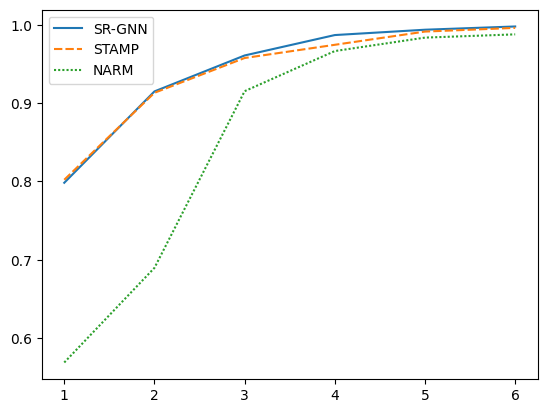

In [8]:
hit_rate = dict()
for model in ["SR-GNN", "STAMP", "NARM"]:
    hit_rate[model] = [df[model]["P@"+str(i)].mean() for i in range(1,MAX_HIT_RATE+1)]

df_tmp = pd.DataFrame(hit_rate, index=range(1,MAX_HIT_RATE+1))
display(df_tmp)

g = sns.lineplot(data=df_tmp)
g.set_xticks(df_tmp.index)
plt.savefig('tmp/hit_rate.pdf',bbox_inches='tight')
plt.show()

# Attention Correlations

In [9]:
# Item correlation
cols = ["x_"+str(i) for i in range(1,NB_ITEMS+1)] + ["y_"+str(i) for i in range(1,NB_ITEMS+1)]

for model in ["SR-GNN", "STAMP", "NARM"]:
    data = []
    for idx, row in df[model].iterrows():
        attention = [np.nan for i in range(1,NB_ITEMS+1)]
        for pos, item in enumerate(row["Model_input"]):
            attention[item-1] = row["Model_attention"][pos]
        prediction = [0 for i in range(1,NB_ITEMS+1)]
        for pos, item in enumerate(row["Model_prediction"]):
            prediction[item-1] = len(row["Model_prediction"]) - pos
        
        data.append(attention + prediction)

    df_tmp = pd.DataFrame(data, columns=cols)
    #display(df_tmp)
    my_corr_mat = df_tmp.corr()
    my_corr_mat = (my_corr_mat-my_corr_mat.min())/(my_corr_mat.max() - my_corr_mat.min())
    my_corr_mat.drop(["x_"+str(i) for i in range(1,NB_ITEMS+1)], axis=0, inplace=True)
    my_corr_mat.drop(["y_"+str(i) for i in range(1,NB_ITEMS+1)], axis=1, inplace=True)
    my_corr_mat = my_corr_mat.fillna(0)
    my_corr_mat = my_corr_mat.rename(columns={"x_"+str(i):"att_"+str(i) for i in range(1,NB_ITEMS+1)})
    my_corr_mat = my_corr_mat.rename(index={"y_"+str(i):"pred_"+str(i) for i in range(1,NB_ITEMS+1)})
    #display(my_corr_mat)

    plt.figure(figsize=(12,6))
    sns.heatmap(my_corr_mat, linewidths=1, annot=False, cmap='viridis',  fmt='0.2f')
    plt.yticks(rotation=0)
    plt.title(model+" item attention/prediction correlation", y=-0.1)
    plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.savefig("tmp/attention_correlation_"+model+".pdf",bbox_inches='tight')